<b><u>Exercises:</u></b><br>
<b>E01:</b> Tune the hyperparameters of the training to beat my best validation loss of 2.2<br>
<b>Results:</b> Best dev set loss 2.174577236175537 for embedding dimension = 1, number of hidden neurons = 250 and context length = 6.

<b>E02:</b> I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?<br>
<b>Results:</b> Yes I tuned the initialization of the weights matrices (W1, W2) by multiplying a value k which would make the probability more uniform at the start (ideally it should be -log(1/27) approximately 3.295836) but by trying different values of k, I got the following results - "Uniform loss = 3.5598788261413574 for k = 9.999999974752427e-07". I futher trained the model with hyperparameters (only change was hn = 200) from the previous exercise and also multiplied k to the weights matrices and trained them (lesser epochs compared to the previous approaches tried till now and also the starting loss was already low) and I got training loss at the end 1.7584 (I used mini-batches) and I evaluated the loss on the train, dev and test set and I got the following results as follows - 2.1294307708740234, 2.1659955978393555 and 2.168989658355713 respectively. 

<b>E03:</b> Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?<br>
<b>Results:</b> Skimmed through the paper, was able to map the implementation of the character level MLP to the paper's ideas and expirements. Will come back to this exercise in the future and try with words. 

In [2]:
# E01

In [3]:
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [6]:
len(words)

32033

In [7]:
# run only once
import random

random.seed(7)
random.shuffle(words)

In [8]:
# build the dataset
# Note: things you can play with here - context_length

def build_dataset(words, context_size):
    block_size = context_size
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            Y.append(ix)
            X.append(context)
            # print(f'{''.join(itos[i] for i in context)} --> {c}')
            context = context[1:] + [ix]
        # print('\n')
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

context_length = 6
Xtr, Ytr = build_dataset(words[:n1], context_length)
Xdev, Ydev = build_dataset(words[n1:n2], context_length)
Xte, Yte = build_dataset(words[n2:], context_length)

In [9]:
min(len(w) for w in words)

2

In [10]:
max(len(w) for w in words)

15

In [11]:
int((sum(len(w) for w in words)) / len(words))

6

In [12]:
len_freq = {}
for w in words:
    l = len(w)
    len_freq[l] = len_freq.get(l, 0) + 1
sorted(len_freq.items(), key=lambda x : x[1], reverse=True)

[(6, 9657),
 (5, 7133),
 (7, 6819),
 (8, 3108),
 (4, 2983),
 (9, 1118),
 (3, 575),
 (10, 380),
 (11, 128),
 (2, 65),
 (13, 30),
 (12, 29),
 (14, 6),
 (15, 2)]

In [13]:
# Note: 
# avg length is 6, maybe context length we can try between 2 - 6

In [14]:
context_length

6

In [15]:
Xtr.shape, Ytr.shape

(torch.Size([182534, 6]), torch.Size([182534]))

In [16]:
# initialize the network 
# things to play with here - embedding dimension, no of neurons in hidden layer
m = 10 # embedding dimension
hn = 200 # number of neurons in hidden layer

g = torch.Generator().manual_seed(3455271)
C = torch.randn((27, m), generator=g)
W1 = torch.randn((m * context_length, hn), generator=g)
b1 = torch.randn(hn, generator=g)
W2 = torch.randn((hn, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [17]:
sum(p.nelement() for p in parameters) # total no of parameters

17897

In [18]:
for p in parameters:
    p.requires_grad = True

In [19]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [20]:
lri = []
lossi = []
stepi = []

In [21]:
batch_size = 32
steps = 200000

In [22]:
for i in range(steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    
    # forward pass
    emb = C[Xtr[ix]] # (27, m), (batch size, context) --> (batch size, context, m)
    h = torch.tanh(emb.view(-1, context_length*m) @ W1 + b1) # (batch size, context, m), (context*m, hn) --> (batch size, context*m), (context*m, hn) --> (batch size, hn)
    logits = h @ W2 + b2 # (batch size, hn), (hn, 27) --> (batch size, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update weights
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # check stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())


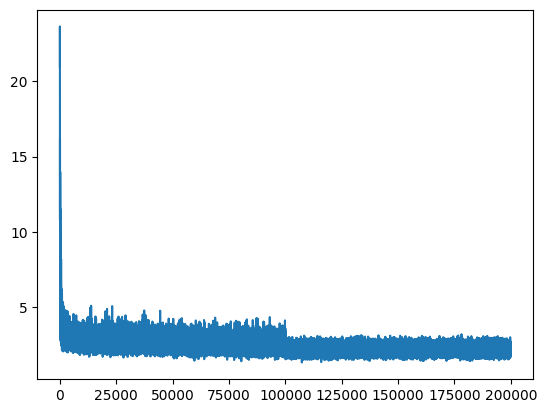

In [23]:
plt.plot(stepi, lossi)

In [24]:
loss

tensor(2.1207, grad_fn=<NllLossBackward0>)

In [25]:
emb = C[Xtr] 
h = torch.tanh(emb.view(-1, context_length*m) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.2040038108825684


In [25]:
emb = C[Xdev] 
h = torch.tanh(emb.view(-1, context_length*m) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.2314260005950928


In [26]:
context_length

6

In [26]:
# sample from the model
g = torch.Generator().manual_seed(3647895+10)

for _ in range(50):
    
    out = []
    context = [0] * context_length # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

esaskelle.
kinina.
fyller.
mansu.
mayie.
manrerl.
alielin.
dyreni.
kohani.
penmly.
maarilyn.
revelralina.
gololia.
getk.
zaildi.
jodise.
joraefa.
lolte.
sotewellaeleah.
mennahia.
mhando.
meynav.
yah.
elrand.
ondreglard.
khar.
kidiya.
prauna.
donenniigh.
aleean.
ketriin.
maliane.
eexthonn.
stian.
birlinga.
matcasia.
maionna.
jiliiah.
alahni.
darira.
imeaselena.
revon.
carydhey.
jaccy.
ovdou.
sokaxnie.
jorilyna.
dailee.
jahlan.
fordliasna.


In [27]:
# playing with different settings of hyperparameters to get lowest dev set loss
# then will use those settings and lower the loss even further 

In [28]:
overall_start_time = time.time()

with open("results.log", "a") as log_file:
    log_file.write("Time_taken, Dev_set_loss, Train_set_loss, Train_loss, Context_length, Embedding_dim, Hidden_neurons\n")

batch_size = 32
steps = 1000

context_lengths = [i for i in range(1, 15)]
embedding_dimensions = [i for i in range(1, 20)]
hidden_neurons = [i for i in range(50, 550, 50)]

Xtr_opt, Ytr_opt = None, None
Xdev_opt, Ydev_opt = None, None
context_length_opt = None
embedding_dimension_opt = None
hidden_neuron_opt = None
parameters_opt = None
parameters_cnt_opt = None
train_loss_opt = None
eval_train_loss_opt = None
lowest_dev_set_loss = float('inf')

for context_length in context_lengths:
    start_time = time.time()
    
    # build the dataset for a particular context length
    Xtr, Ytr = build_dataset(words[:n1], context_length)
    Xdev, Ydev = build_dataset(words[n1:n2], context_length)

    # initialize with network with particular embedding dimension and no of hidden neurons
    for m in embedding_dimensions:
        for hn in hidden_neurons:
            
            # initialize the network 
            g = torch.Generator().manual_seed(3455271)
            C = torch.randn((27, m), generator=g)
            W1 = torch.randn((m * context_length, hn), generator=g)
            b1 = torch.randn(hn, generator=g)
            W2 = torch.randn((hn, 27), generator=g)
            b2 = torch.randn(27, generator=g)
            parameters = [C, W1, b1, W2, b2]
            
            params_cnt = sum(p.nelement() for p in parameters) # total no of parameters
            
            for p in parameters:
                p.requires_grad = True

            # training with fixed batch size and steps
            for i in range(steps):
            
                # minibatch construct
                ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
                
                # forward pass
                emb = C[Xtr[ix]] # (27, m), (batch size, context) --> (batch size, context, m)
                h = torch.tanh(emb.view(-1, context_length*m) @ W1 + b1) # (batch size, context, m), (context*m, hn) --> (batch size, context*m), (context*m, hn) --> (batch size, hn)
                logits = h @ W2 + b2 # (batch size, hn), (hn, 27) --> (batch size, 27)
                train_loss = F.cross_entropy(logits, Ytr[ix])
                
                # backward pass
                for p in parameters:
                    p.grad = None
                train_loss.backward()
                
                # update weights
                lr = 0.1 if i < 500 else 0.01
                for p in parameters:
                    p.data += -lr * p.grad
                
            # evaluate on whole training set
            emb = C[Xtr] 
            h = torch.tanh(emb.view(-1, context_length*m) @ W1 + b1)
            logits = h @ W2 + b2 
            eval_train_loss = F.cross_entropy(logits, Ytr)
    
            # evaluate on whole dev set
            emb = C[Xdev] 
            h = torch.tanh(emb.view(-1, context_length*m) @ W1 + b1)
            logits = h @ W2 + b2 
            eval_dev_loss = F.cross_entropy(logits, Ydev)
            
            if eval_dev_loss.item() < lowest_dev_set_loss:
                lowest_dev_set_loss = eval_dev_loss.item()
                Xtr_opt, Ytr_opt = Xtr, Ytr
                Xdev_opt, Ydev_opt = Xdev, Ydev
                context_length_opt = context_length
                embedding_dimension_opt = m
                hidden_neuron_opt = hn
                parameters_opt = parameters
                parameters_cnt_opt = params_cnt
                train_loss_opt = train_loss.item()
                eval_train_loss_opt = eval_train_loss.item()

            end_time = time.time()
            with open("results.log", "a") as log_file:
                log_file.write(f"{end_time - start_time:.2f} seconds, {eval_dev_loss.item()}, {eval_train_loss.item()}, {train_loss.item()}, {context_length}, {m}, {hn}\n")
            print(f"time_taken: {end_time - start_time:.2f} seconds, Dev set loss: {eval_dev_loss.item()}, train_set_loss: {eval_train_loss.item()}, train_loss: {train_loss.item()}, context_length: {context_length}, embedding_dim: {m}, hidden_neurons: {hn}\n")
                

print(f'''\n\n<-------------Results------------->\n
Lowest Dev set loss is {lowest_dev_set_loss}:\n
1) context length : {context_length_opt}\n
2) embedding dimension : {embedding_dimension_opt}\n
3) no of hidden neurons : {hidden_neuron_opt}\n
4) no of parameters : {parameters_cnt_opt}\n
5) training loss : {train_loss_opt}\n
6) train set loss : {eval_train_loss_opt}''')

overall_end_time = time.time()
print(f"Total time for all configurations: {overall_end_time - overall_start_time:.2f} seconds")

time_taken: 0.33 seconds, Dev set loss: 2.66921329498291, train_set_loss: 2.6785495281219482, train_loss: 2.6602072715759277, context_length: 1, embedding_dim: 1, hidden_neurons: 50

time_taken: 0.45 seconds, Dev set loss: 2.664059638977051, train_set_loss: 2.667417049407959, train_loss: 2.639204502105713, context_length: 1, embedding_dim: 1, hidden_neurons: 100

time_taken: 0.61 seconds, Dev set loss: 2.680180072784424, train_set_loss: 2.6841955184936523, train_loss: 2.5486977100372314, context_length: 1, embedding_dim: 1, hidden_neurons: 150

time_taken: 0.80 seconds, Dev set loss: 2.619988203048706, train_set_loss: 2.6265110969543457, train_loss: 2.545046329498291, context_length: 1, embedding_dim: 1, hidden_neurons: 200

time_taken: 0.99 seconds, Dev set loss: 2.64654278755188, train_set_loss: 2.6504135131835938, train_loss: 2.452277183532715, context_length: 1, embedding_dim: 1, hidden_neurons: 250

time_taken: 1.20 seconds, Dev set loss: 2.675804615020752, train_set_loss: 2.67025

In [29]:
# All in one place

In [30]:
context_length = 6

In [31]:
# build the dataset
Xtr, Ytr = build_dataset(words[:n1], context_length)
Xdev, Ydev = build_dataset(words[n1:n2], context_length)
Xte, Yte = build_dataset(words[n2:], context_length)

In [32]:
Xtr.shape, Ytr.shape

(torch.Size([182534, 6]), torch.Size([182534]))

In [33]:
# initialize the network

m = 1 # embedding dimension
hn = 250 # number of neurons in hidden layer

g = torch.Generator().manual_seed(3455271)
C = torch.randn((27, m), generator=g)
W1 = torch.randn((m * context_length, hn), generator=g)
b1 = torch.randn(hn, generator=g)
W2 = torch.randn((hn, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [34]:
sum(p.nelement() for p in parameters) # total no of parameters

8554

In [35]:
for p in parameters:
    p.requires_grad = True

In [36]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [37]:
batch_size = 32
steps = 1000000

In [38]:
lri = []
lossi = []
stepi = []

In [54]:
for i in range(steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    
    # forward pass
    emb = C[Xtr[ix]] # (27, m), (batch size, context) --> (batch size, context, m)
    h = torch.tanh(emb.view(-1, context_length*m) @ W1 + b1) # (batch size, context, m), (context*m, hn) --> (batch size, context*m), (context*m, hn) --> (batch size, hn)
    logits = h @ W2 + b2 # (batch size, hn), (hn, 27) --> (batch size, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update weights
    # lr = lrs[i]
    lr = 0.1 if i < 500000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # check stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

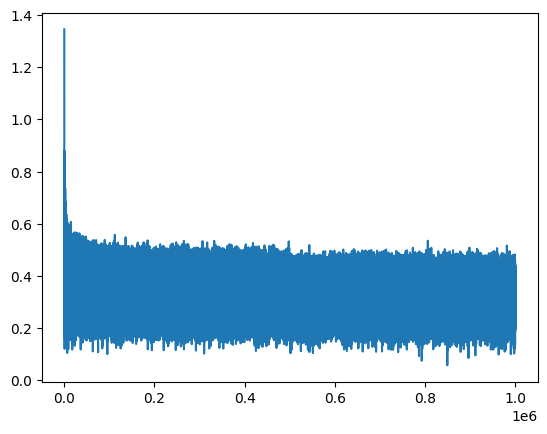

In [55]:
plt.plot(stepi, lossi)

In [56]:
loss

tensor(2.1204, grad_fn=<NllLossBackward0>)

In [57]:
emb = C[Xtr] 
h = torch.tanh(emb.view(-1, context_length*m) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.1357901096343994


In [58]:
emb = C[Xdev] 
h = torch.tanh(emb.view(-1, context_length*m) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.174577236175537


In [59]:
# sample from the model
g = torch.Generator().manual_seed(123456789)

for _ in range(50):
    
    out = []
    context = [0] * context_length # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

kyner.
ezah.
nyaton.
srena.
karlin.
aulusteka.
jevel.
lax.
jahse.
aanvae.
mayna.
laigan.
janth.
kami.
browliana.
rianoly.
hayzeey.
anger.
azada.
chaylin.
maryna.
tainabyn.
braa.
madrea.
kowina.
harat.
amyla.
prami.
fromyin.
vaudir.
baraya.
mariya.
jarin.
lyshia.
janolaja.
oxaysa.
baryla.
jaymer.
cia.
zebica.
yahzi.
miyat.
karey.
calaje.
zalyn.
ghyil.
anoni.
jayse.
alelia.
thandrya.


In [92]:
# E02

In [111]:
# build the dataset

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

context_length = 6 # we have got this from E01
Xtr, Ytr = build_dataset(words[:n1], context_length)
Xdev, Ydev = build_dataset(words[n1:n2], context_length)
Xte, Yte = build_dataset(words[n2:], context_length)

Loss = 3.5598788261413574 for k = 9.999999974752427e-07

Loss = 3.5598788261413574 for k = 1.0162650596612366e-06

Loss = 3.5598788261413574 for k = 1.0327947848054464e-06

Loss = 3.5598793029785156 for k = 1.04959326563403e-06

Loss = 3.5598788261413574 for k = 1.0666649359336589e-06

Loss = 3.5598793029785156 for k = 1.0840143431778415e-06

Loss = 3.5598793029785156 for k = 1.1016459211532492e-06

Loss = 3.5598788261413574 for k = 1.1195643310202286e-06

Loss = 3.5598793029785156 for k = 1.1377741202522884e-06

Loss = 3.5598788261413574 for k = 1.1562801773834508e-06

Loss = 3.5598793029785156 for k = 1.1750871635740623e-06

Loss = 3.5598793029785156 for k = 1.1942000810449827e-06

Loss = 3.5598793029785156 for k = 1.213623818330234e-06

Loss = 3.5598793029785156 for k = 1.2333634913375136e-06

Loss = 3.5598793029785156 for k = 1.253424215974519e-06

Loss = 3.5598793029785156 for k = 1.2738113355226233e-06

Loss = 3.5598793029785156 for k = 1.2945299658895237e-06

Loss = 3.5598793029

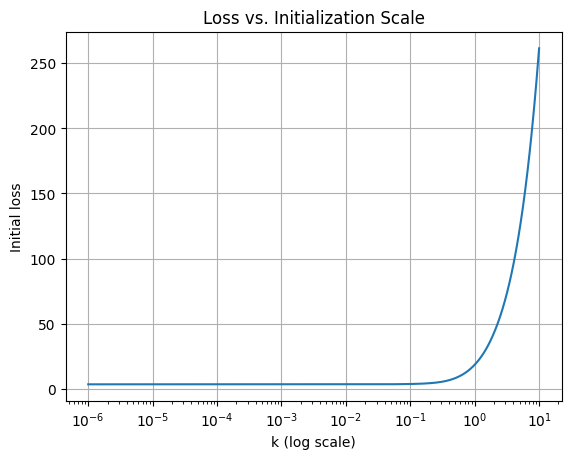

In [94]:
# initialize the network but write a function to pass 1000 k values with values 10^-6 to 10^1 each are logarithmically separated
# what we are going to do is multiply the hidden layer and output layer with this constant to make the
# weights smaller and closer to zero, we want the initial loss (just a single forward pass) to be approximately 3.2958 or closer to it
# why 3.2958? because -log(1/27) ie all the probablities are uniformly distributed
# now if we want the probablities to be uniform we need to tweak the weights with k


losses = []
k_list = torch.logspace(-6, 1, steps=1000).tolist()
m = 1 # embedding dimension
hn = 200 # number of neurons in hidden layer

def init_network(k):
    # initialize the network
    g = torch.Generator().manual_seed(3455271)
    C = torch.randn((27, m), generator=g)
    W1 = torch.randn((m * context_length, hn), generator=g) * k
    b1 = torch.randn(hn, generator=g)
    W2 = torch.randn((hn, 27), generator=g) * k
    b2 = torch.randn(27, generator=g)
    return C, W1, b1, W2, b2

def forward_pass(C, W1, b1, W2, b2, X, Y):
    emb = C[X] # (27, m), (no of inputs, context length) --> (no of inputs, context length, m)
    h = torch.tanh(emb.view(-1, context_length*m) @ W1 + b1) # (no of inputs, context lenghth * m) * (context length * m, hn) --> (no of inputs, hn)
    logits = h @ W2 + b2 # (no of inputs, , hn) * (hn, 27) --> (no of inputs, 27)
    loss = F.cross_entropy(logits, Y)
    return loss.item()

smallest_gap = float('inf')
closest_to_target = None
k_target = None
for k in k_list:
    C, W1, b1, W2, b2 = init_network(k)
    loss = forward_pass(C, W1, b1, W2, b2, Xtr, Ytr)
    losses.append(loss)
    if abs(loss - 3.29) < smallest_gap:
        smallest_gap = abs(loss - 3.29)
        closest_to_target, k_target = loss, k
    print(f"Loss = {loss} for k = {k}\n")

print(f"\n\n Uniform loss = {closest_to_target} for k = {k_target}")
plt.semilogx(k_list, losses)
plt.xlabel("k (log scale)")
plt.ylabel("Initial loss")
plt.title("Loss vs. Initialization Scale")
plt.grid(True)
plt.show()


In [100]:
# initialize the model with the k value and train it with the previous values for the hyperparameters

m = 1
hn = 200
k = 9.999999974752427e-07

g = torch.Generator().manual_seed(3455271)
C = torch.randn((27, m), generator=g)
W1 = torch.randn((m * context_length, hn), generator=g) * k
b1 = torch.randn(hn, generator=g)
W2 = torch.randn((hn, 27), generator=g) * k
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [101]:
sum(p.nelement() for p in parameters)

6854

In [102]:
for p in parameters:
    p.requires_grad = True

In [110]:
lossi_log = []
stepi = []

In [132]:
# train the network

batch_size = 32
steps = 1000000

for i in range(steps):
    # forward pass
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, context_length * m) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update weights
    lr = 0.01 if steps < 500000 else 0.001
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi_log.append(loss.log10().item())

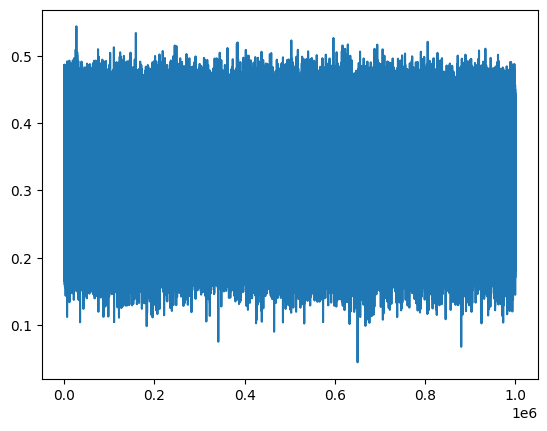

In [133]:
plt.plot(stepi, lossi_log)

In [134]:
loss

tensor(1.7584, grad_fn=<NllLossBackward0>)

In [135]:
# train set evaluation
emb = C[Xtr]
h = torch.tanh(emb.view(-1, context_length * m) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.1294307708740234


In [136]:
# dev set evaluation
emb = C[Xdev]
h = torch.tanh(emb.view(-1, context_length * m) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1659955978393555


In [138]:
# test set evaluation
emb = C[Xte]
h = torch.tanh(emb.view(-1, context_length * m) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
print(loss.item())

2.168989658355713


In [137]:
# sample from the model
g = torch.Generator().manual_seed(123456789)

for _ in range(50):
    
    out = []
    context = [0] * context_length # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

kyarlee.
chany.
toctson.
shad.
zonxaul.
wanka.
jevec.
lau.
jahson.
anzaed.
tyndyna.
grish.
napsan.
dyar.
wamana.
rianory.
haraeny.
avem.
canasa.
chanu.
kamon.
nadtil.
keylib.
tacmad.
carton.
jalur.
stlamy.
coptton.
farmy.
covmu.
srevura.
mira.
imam.
naively.
kyasom.
tiajan.
annali.
andalina.
moralia.
zelicia.
shariesya.
zarrey.
cavan.
kaslyn.
ghyli.
anoni.
jayke.
amelia.
thandrori.
amaris.
